In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
# 读取四张表的数据
# 读取了订单和产品id的关联
prior = pd.read_csv("./data/instacart/order_products__prior.csv")

In [3]:
# 产品id，与过道的对应
products = pd.read_csv("./data/instacart/products.csv")

In [4]:
# 订单id和用户id的对应
orders = pd.read_csv("./data/instacart/orders.csv")

In [5]:
# 超市的过道，过道放的产品的品类
aisles = pd.read_csv("./data/instacart/aisles.csv")

In [6]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products.head()  # 产品id，产品名称，过道id

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
orders.head()  # 订单id,用户id

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
aisles.head()  # 过道id，对应过道放了哪些产品类别

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
# 合并四张表到一张表(用户-物品类别)
# 订单表和产品表关联
# 用户买了哪些订单，订单里面有哪些产品，产品对应的过道，过道对应的产品类别
_mg = pd.merge(prior, products, on=['product_id', 'product_id'])
_mg = pd.merge(_mg, orders, on=['order_id', 'order_id'])
mt = pd.merge(_mg, aisles, on=['aisle_id', 'aisle_id'])

In [11]:
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients
5,2,17794,6,1,Carrots,83,4,202279,prior,3,5,9,8.0,fresh vegetables
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,202279,prior,3,5,9,8.0,doughs gelatins bake mixes
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,202279,prior,3,5,9,8.0,spreads
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,202279,prior,3,5,9,8.0,packaged vegetables fruits
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,205970,prior,16,5,17,12.0,yogurt


In [12]:
mt.shape

(32434489, 14)

In [13]:
mt.isnull().sum() / mt.shape[0]  # 数据缺失率，没有缺失值

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    0.06407
aisle                     0.00000
dtype: float64

In [14]:
# 交叉表(特殊的分组工具)，内存不够进行聚类
cross = pd.crosstab(mt['user_id'], mt['aisle'])

In [15]:
cross.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [16]:
# 针对20万用户，有134个特征
cross.shape

(206209, 134)

In [17]:
type(cross)

pandas.core.frame.DataFrame

In [18]:
# 进行主成分分析
pca = PCA(n_components=0.9)

In [19]:
data = pca.fit_transform(cross)
data.shape

(206209, 27)

In [20]:
type(data)

numpy.ndarray

In [21]:
# 把样本数量减少，为了下面画图方便，这里取500个样本
x = data[:500]
x.shape

(500, 27)

In [22]:
x[0:10]

array([[-2.42156587e+01, -2.42942720e+00, -2.46636975e+00,
         1.45686388e-01,  2.69042476e-01, -1.43293209e+00,
        -2.14067666e+00,  2.73803122e+00, -2.71431623e+00,
        -1.74313529e+00, -1.13632718e+00,  6.73601069e-01,
        -1.65070735e+00,  2.83802486e+00,  5.89384489e+00,
        -7.84312891e+00, -4.84010146e+00, -3.22598697e+00,
        -4.58007571e+00,  7.77403349e-01, -3.69912893e+00,
         1.90721439e+00, -2.99538594e+00, -7.72922878e-01,
         6.86800336e-01,  1.69439402e+00, -2.34323022e+00],
       [ 6.46320806e+00, -3.67511165e+01,  8.38255336e+00,
        -1.50975303e+01, -6.92093785e+00, -9.78375183e-01,
        -6.01156653e+00, -3.78772465e+00, -8.18074883e+00,
        -9.04086141e+00, -5.61352902e+00, -1.11325323e+00,
         2.96702911e+00, -4.73123497e+00, -9.11472283e+00,
        -2.14709471e-01,  1.29694031e+00, -7.37605505e-01,
        -7.37401979e-01,  7.40042249e-01, -9.13382968e-02,
         5.15128465e+00,  4.58481528e+00,  3.23789431e+

In [23]:
x.max()

np.float64(407.1856341824979)

In [24]:
x.min()

np.float64(-144.56766126863667)

In [25]:
# 假设用户一共分为四个类别
# n_clusters是分为几个类别，是主要的超参
km = KMeans(n_clusters=4)

In [26]:
km.fit(x)  # 开始训练

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [27]:
# 开始预测
predict = km.predict(x)

In [28]:
print(predict)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0
 0 0 0 1 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 0 3 0 0 0 2 0 0 0 0 0 0 0 0
 1 0 0 0 2 0 0 0 0 2 2 2 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 2 0 1 0 0 0 2 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 1 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 2 0 0 0 0 0 0 

In [29]:
import numpy as np

np.unique(predict)

array([0, 1, 2, 3], dtype=int32)

In [30]:
# 显示聚类的结果
plt.figure(figsize=(20, 20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

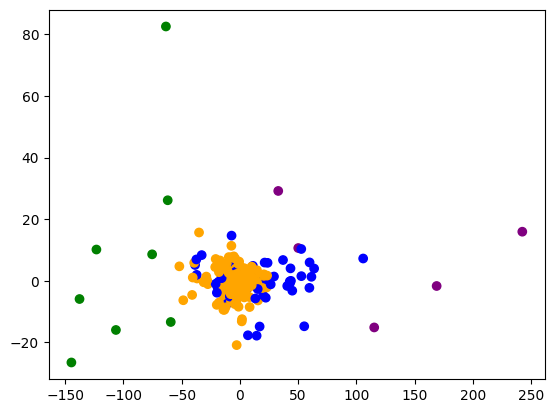

In [31]:
# 建立四个颜色的列表
colored = ['orange', 'green', 'blue', 'purple']
colr = [colored[i] for i in predict]  # 根据类别给每个样本赋予颜色
# 去选择任意两个特征来看聚类的图。我是第2和20
plt.scatter(x[:, 1], x[:, 19], color=colr)

In [32]:
# 评判聚类效果，轮廓系数，聚类效果很难超过0.7，可以通过这个得分去调整上面KMeans的n_clusters
silhouette_score(x, predict)

0.6262056808876679

In [33]:
# 改为2时的结果
km = KMeans(n_clusters=3)
km.fit(x)  # 开始训练
predict = km.predict(x)
print(silhouette_score(x, predict))
predict

0.6917761534307684


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
# 通过分类后数据，去看原始样本的特点
cross.iloc[0]

aisle
air fresheners candles           0
asian foods                      0
baby accessories                 0
baby bath body care              0
baby food formula                0
                                ..
trash bags liners                0
vitamins supplements             0
water seltzer sparkling water    0
white wines                      0
yogurt                           1
Name: 1, Length: 134, dtype: int64

In [35]:
predict[26]
cross.iloc[26]

aisle
air fresheners candles             0
asian foods                        4
baby accessories                   0
baby bath body care                0
baby food formula                  0
                                ... 
trash bags liners                  0
vitamins supplements               0
water seltzer sparkling water     92
white wines                        0
yogurt                           150
Name: 27, Length: 134, dtype: int64

In [36]:
# 改为3时的结果
km = KMeans(n_clusters=3)
km.fit(x)  # 开始训练
predict = km.predict(x)
silhouette_score(x, predict)

0.6377392240924092

# 四种异常值检测方法

## 1.基于分位数找异常值

In [37]:
np.random.seed(42)  # 为了结果的可重复性设置的随机种子
X = np.random.rand(50, 1)  # 二维数据
X

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848],
       [0.15601864],
       [0.15599452],
       [0.05808361],
       [0.86617615],
       [0.60111501],
       [0.70807258],
       [0.02058449],
       [0.96990985],
       [0.83244264],
       [0.21233911],
       [0.18182497],
       [0.18340451],
       [0.30424224],
       [0.52475643],
       [0.43194502],
       [0.29122914],
       [0.61185289],
       [0.13949386],
       [0.29214465],
       [0.36636184],
       [0.45606998],
       [0.78517596],
       [0.19967378],
       [0.51423444],
       [0.59241457],
       [0.04645041],
       [0.60754485],
       [0.17052412],
       [0.06505159],
       [0.94888554],
       [0.96563203],
       [0.80839735],
       [0.30461377],
       [0.09767211],
       [0.68423303],
       [0.44015249],
       [0.12203823],
       [0.49517691],
       [0.03438852],
       [0.9093204 ],
       [0.25877998],
       [0.66252228],
       [0.31171108],
       [0.520

In [38]:
X[0, 0] = 3
X[1, 0] = 2

In [39]:
import pandas as pd

# 假设df是一个Pandas DateFrame，包含了你想要分析的数据集
# 'column_name'是你想要检测异常值的列名

# 随机一个dataframe
df = pd.DataFrame(X, columns=['column_name'])

# 设置分位数，例如四分位数
Q1 = df['column_name'].quantile(0.25)  # 第一四分位数(25%)
Q3 = df['column_name'].quantile(0.75)  # 第三四分位数(75%)

# 计算四分位数范围(IQR)
IQR = Q3 - Q1

# 定义下界和上界来识别异常值
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 标记异常值
df['outlier'] = df['column_name'].apply(lambda x: 'Yes' if x < lower_bound or x > upper_bound else 'No')

# 打印出被标记为异常值的行
df[df['outlier'] == 'Yes']

,column_name,outlier
0,3.0,Yes
1,2.0,Yes
